In [1]:
%load_ext autoreload
%autoreload 2

import os

subj = "phase2/Subj3"

UNIQUE_VALUES_THRESHOLD = 200

exp = "exp_reduced_flow"
os.makedirs(f"{subj}/{exp}", exist_ok = True)

In [2]:
import typing

import mne
import numpy
import pandas
import IPython.display
import sklearn.metrics
import matplotlib.colors
import sklearn.preprocessing
import sklearn.decomposition
import matplotlib.pyplot as plt

import SDA.topology
import SDA.analytics
import SDA.clustquality
import SDA.stageprocess

### Data

Opening raw data file phase2/Subj3/src/data_rr_filt-raw.fif...
    Range : 0 ... 663000 =      0.000 ...  1326.000 secs
Ready.
Reading d:\HSE\year-3\HSE\CourseProject\phase2\Subj3\src\epochs_filt_rr-epo.fif ...
    Found the data of interest:
        t =    -500.00 ...     498.00 ms
        0 CTF compensation matrices available
Not setting metadata
1249 matching events found
No baseline correction applied
0 projection items activated
Stages:  8
No projector specified for this dataset. Please consider the method self.add_proj.


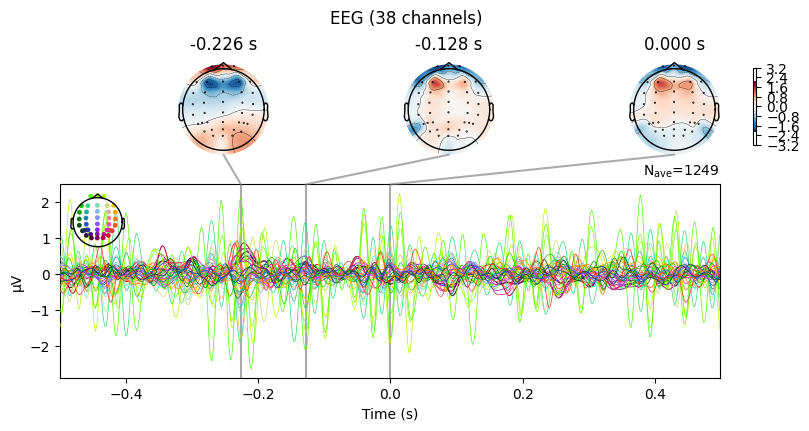

(1249, 38, 500)


In [3]:
raw_data = mne.io.read_raw_fif(f"{subj}/src/data_rr_filt-raw.fif").drop_channels(ch_names = [ 'IVEOG', 'IHEOG' ])
epochs = mne.read_epochs(f"{subj}/src/epochs_filt_rr-epo.fif").drop_channels(ch_names = [ 'IVEOG', 'IHEOG' ])
N_STAGES = int(numpy.loadtxt(f"{subj}/src/n_stages.txt"))
print('Stages: ', N_STAGES)

epochs.average().plot_joint().savefig(f"{subj}/{exp}/eeg.svg")
data = epochs.get_data(copy = True)
print(data.shape)

### Features

In [4]:
per_channel_folder = f"{subj}/{exp}/features/per_channel"
os.makedirs(per_channel_folder, exist_ok = True)
per_channel_extractor = SDA.topology.PerChannelFeatureExtractor(n_jobs = -1, folder = per_channel_folder, reduced = True)
per_channel_features = per_channel_extractor.extract(data)

dissimilarity_folder = f"{subj}/{exp}/features/dissimilarity"
os.makedirs(dissimilarity_folder, exist_ok = True)
dissimilarity_extractor = SDA.topology.DissimilarityFeatureExtractor(n_jobs = -1, folder = dissimilarity_folder, reduced = True)
dissimilarity_features = dissimilarity_extractor.extract(data)

overall_folder = f"{subj}/{exp}/features/overall"
os.makedirs(overall_folder, exist_ok = True)
overall_extractor = SDA.topology.OverallFeatureExtractor(n_jobs = -1, folder = overall_folder, reduced = True)
overall_features = overall_extractor.extract(data)

all_features = pandas.concat([
    per_channel_features,
    dissimilarity_features,
    overall_features
], axis = 1)

all_features.to_feather(f"{subj}/{exp}/features/all_features.feather")
display(all_features)

Got features from phase2/Subj3/exp_reduced_flow/features/per_channel/features.feather
Got features from phase2/Subj3/exp_reduced_flow/features/overall/features.feather


,channel-0 landscape dim-1 max,channel-0 landscape dim-1 mean,channel-0 landscape dim-1 std,channel-0 landscape dim-1 sum,channel-0 landscape dim-1 norm-1,channel-0 landscape dim-1 norm-2,channel-0 landscape dim-2 max,channel-0 landscape dim-2 mean,channel-0 landscape dim-2 std,channel-0 landscape dim-2 sum,...,overall bd2 dim-2 std,overall bd2 dim-2 sum,overall bd2 dim-2 norm-1,overall bd2 dim-2 norm-2,overall bd2 dim-3 max,overall bd2 dim-3 mean,overall bd2 dim-3 std,overall bd2 dim-3 sum,overall bd2 dim-3 norm-1,overall bd2 dim-3 norm-2
0,0.000003,1.887641e-07,6.184880e-07,0.000019,0.000019,0.000006,7.970370e-07,2.389350e-08,1.206614e-07,0.000002,...,0.000006,0.004127,0.004127,0.000610,0.000099,0.000093,0.000003,0.000742,0.000742,0.000262
1,0.000003,1.623541e-07,6.300686e-07,0.000016,0.000016,0.000007,1.585109e-06,5.379894e-08,2.623291e-07,0.000005,...,0.000016,0.005792,0.005792,0.000870,0.000147,0.000130,0.000015,0.001296,0.001296,0.000413
2,0.000003,2.527809e-07,7.818648e-07,0.000025,0.000025,0.000008,4.816338e-07,1.239250e-08,6.404758e-08,0.000001,...,0.000011,0.006145,0.006145,0.000804,0.000121,0.000106,0.000006,0.002111,0.002111,0.000473
3,0.000005,3.429387e-07,1.021065e-06,0.000034,0.000034,0.000011,1.800802e-06,3.011788e-08,1.947261e-07,0.000003,...,0.000009,0.006391,0.006391,0.000888,0.000145,0.000135,0.000008,0.000811,0.000811,0.000332
4,0.000005,3.065088e-07,8.208435e-07,0.000031,0.000031,0.000009,7.497021e-07,2.810548e-08,1.309189e-07,0.000003,...,0.000008,0.004386,0.004386,0.000713,0.000129,0.000124,0.000003,0.000991,0.000991,0.000350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1244,0.000005,4.846944e-07,1.236994e-06,0.000048,0.000048,0.000013,1.154854e-06,3.531663e-08,1.810577e-07,0.000004,...,0.000022,0.004264,0.004264,0.000877,0.000232,0.000208,0.000015,0.002501,0.002501,0.000724
1245,0.000006,3.109374e-07,1.063642e-06,0.000031,0.000031,0.000011,1.224462e-06,6.907567e-08,2.513955e-07,0.000007,...,0.000009,0.006786,0.006786,0.000935,0.000149,0.000137,0.000009,0.001644,0.001644,0.000475
1246,0.000007,5.351683e-07,1.240494e-06,0.000054,0.000054,0.000014,1.262865e-06,2.701943e-08,1.476746e-07,0.000003,...,0.000013,0.009139,0.009139,0.001225,0.000191,0.000173,0.000010,0.003283,0.003283,0.000754
1247,0.000006,5.698570e-07,1.361439e-06,0.000057,0.000057,0.000015,2.859710e-06,1.648886e-07,5.161582e-07,0.000016,...,0.000013,0.005520,0.005520,0.000936,0.000189,0.000168,0.000015,0.002864,0.002864,0.000697


In [5]:
features = sklearn.preprocessing.StandardScaler().fit_transform(all_features)
features = pandas.DataFrame(features, columns = all_features.columns)

features.to_feather(f"{subj}/{exp}/features/features.feather")
display(features)

numpy.save(f"{subj}/{exp}/features/features.npy", features.to_numpy())

,channel-0 landscape dim-1 max,channel-0 landscape dim-1 mean,channel-0 landscape dim-1 std,channel-0 landscape dim-1 sum,channel-0 landscape dim-1 norm-1,channel-0 landscape dim-1 norm-2,channel-0 landscape dim-2 max,channel-0 landscape dim-2 mean,channel-0 landscape dim-2 std,channel-0 landscape dim-2 sum,...,overall bd2 dim-2 std,overall bd2 dim-2 sum,overall bd2 dim-2 norm-1,overall bd2 dim-2 norm-2,overall bd2 dim-3 max,overall bd2 dim-3 mean,overall bd2 dim-3 std,overall bd2 dim-3 sum,overall bd2 dim-3 norm-1,overall bd2 dim-3 norm-2
0,-1.360678,-1.159535,-1.353713,-1.159535,-1.159535,-1.311805,-1.371001,-1.016486,-1.213140,-1.016486,...,-0.899450,-1.385803,-1.385803,-1.857305,-2.246454,-2.308498,-0.923304,-1.088124,-1.088124,-1.515935
1,-1.327162,-1.224238,-1.335595,-1.224238,-1.224238,-1.306467,-0.670229,-0.687379,-0.584927,-0.687379,...,1.261602,-1.056842,-1.056842,-1.183607,-1.041255,-1.237394,1.322695,-0.908107,-0.908107,-1.085010
2,-1.292816,-1.002697,-1.098108,-1.002697,-1.002697,-1.078064,-1.651465,-1.143053,-1.464189,-1.143053,...,0.108692,-0.986977,-0.986977,-1.354039,-1.679966,-1.936924,-0.409546,-0.643355,-0.643355,-0.912704
3,-0.640499,-0.781814,-0.723875,-0.781814,-0.781814,-0.737045,-0.478430,-0.947987,-0.884706,-0.947987,...,-0.306800,-0.938500,-0.938500,-1.135860,-1.081288,-1.075496,-0.025711,-1.065707,-1.065707,-1.317438
4,-0.827049,-0.871066,-1.037125,-0.871066,-0.871066,-1.005307,-1.413092,-0.970133,-1.167654,-0.970133,...,-0.479129,-1.334643,-1.334643,-1.589728,-1.495398,-1.404624,-0.975816,-1.007292,-1.007292,-1.263759
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1244,-0.405331,-0.434519,-0.386050,-0.434519,-0.434519,-0.401310,-1.052822,-0.890775,-0.945318,-0.890775,...,2.656209,-1.358799,-1.358799,-1.164789,1.102631,1.054667,1.235783,-0.516414,-0.516414,-0.191977
1245,0.028975,-0.860216,-0.657261,-0.860216,-0.860216,-0.695597,-0.990925,-0.519260,-0.633411,-0.519260,...,-0.169291,-0.860460,-0.860460,-1.016475,-0.976200,-1.022913,0.141945,-0.795107,-0.795107,-0.904707
1246,0.085068,-0.310861,-0.380574,-0.310861,-0.310861,-0.371340,-0.956776,-0.982085,-1.093352,-0.982085,...,0.565556,-0.395323,-0.395323,-0.264268,0.083913,0.018994,0.257290,-0.262227,-0.262227,-0.104314
1247,-0.077666,-0.225875,-0.191353,-0.225875,-0.225875,-0.204599,0.463175,0.535154,0.540656,0.535154,...,0.698893,-1.110555,-1.110555,-1.011669,0.021142,-0.106811,1.290157,-0.398453,-0.398453,-0.267727


### Feature selection

In [11]:
os.makedirs(f"{subj}/{exp}/qsda", exist_ok = True)
qsda = SDA.QSDA(
    n_jobs = 1,
    qsda_n_jobs = 15,
    scores_folder = f"{subj}/{exp}/qsda",

    threshold = 1150,
    min_unique_values = UNIQUE_VALUES_THRESHOLD
)
best_features, scores = qsda.select(features)

best_features.to_feather(f"{subj}/{exp}/qsda/best_features.feather")
numpy.save(f"{subj}/{exp}/qsda/best_features.npy", features.to_numpy())
display(best_features)
display(scores)

Using threshold 0.43


,channel-0 landscape dim-1 mean,channel-0 landscape dim-1 std,channel-0 landscape dim-1 sum,channel-0 landscape dim-1 norm-1,channel-0 landscape dim-1 norm-2,channel-0 landscape dim-2 mean,channel-0 landscape dim-2 sum,channel-0 landscape dim-2 norm-1,channel-0 silhouette-1 dim-1 mean,channel-0 silhouette-1 dim-1 sum,...,overall amplitude-silhouette-1-2 dim-2,overall bd2 all max,overall bd2 all mean,overall bd2 dim-1 max,overall bd2 dim-1 mean,overall bd2 dim-1 norm-2,overall bd2 dim-2 max,overall bd2 dim-2 mean,overall bd2 dim-3 max,overall bd2 dim-3 mean
0,-1.159535,-1.353713,-1.159535,-1.159535,-1.311805,-1.016486,-1.016486,-1.016486,-1.169626,-1.169626,...,-0.302599,-2.259807,-2.379981,-2.100727,-2.354835,-2.192406,-2.214351,-2.402790,-2.246454,-2.308498
1,-1.224238,-1.335595,-1.224238,-1.224238,-1.306467,-0.687379,-0.687379,-0.687379,-0.955629,-0.955629,...,-0.207640,-0.646939,-1.268463,-0.469677,-1.261502,-1.128902,-0.536383,-1.133972,-1.041255,-1.237394
2,-1.002697,-1.098108,-1.002697,-1.002697,-1.078064,-1.143053,-1.143053,-1.143053,-1.096488,-1.096488,...,-0.272842,-1.646894,-1.889980,-1.598843,-1.872958,-1.810590,-1.576699,-1.932908,-1.679966,-1.936924
3,-0.781814,-0.723875,-0.781814,-0.781814,-0.737045,-0.947987,-0.947987,-0.947987,-0.766283,-0.766283,...,-0.219191,-1.247221,-1.423667,-1.337068,-1.443049,-1.444417,-1.235858,-1.323044,-1.081288,-1.075496
4,-0.871066,-1.037125,-0.871066,-0.871066,-1.005307,-0.970133,-0.970133,-0.970133,-0.970491,-0.970491,...,-0.235518,-1.574858,-1.609736,-1.357968,-1.573306,-1.424538,-1.633917,-1.566328,-1.495398,-1.404624
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1244,-0.434519,-0.386050,-0.434519,-0.434519,-0.401310,-0.890775,-0.890775,-0.890775,-0.463541,-0.463541,...,0.294509,0.922454,-0.063279,0.608097,-0.236725,-0.765772,0.606740,0.459173,1.102631,1.054667
1245,-0.860216,-0.657261,-0.860216,-0.860216,-0.695597,-0.519260,-0.519260,-0.519260,-0.704111,-0.704111,...,-0.096251,-1.142818,-1.226489,-0.908464,-1.246405,-1.219498,-1.211088,-1.156014,-0.976200,-1.022913
1246,-0.310861,-0.380574,-0.310861,-0.310861,-0.371340,-0.982085,-0.982085,-0.982085,-0.730153,-0.730153,...,-0.046201,-0.089620,-0.316863,-0.020582,-0.563686,-0.896476,0.022331,-0.011309,0.083913,0.018994
1247,-0.225875,-0.191353,-0.225875,-0.225875,-0.204599,0.535154,0.535154,0.535154,-0.108477,-0.108477,...,-0.068368,-0.151981,-0.290087,0.031612,-0.329085,-0.891143,-0.041620,-0.189913,0.021142,-0.106811


,name,score,mean,variance,unique_values,normalized_score
0,channel-0 landscape dim-1 max,1.594256,2.958224e-16,1.0,1249,0.410963
1,channel-0 landscape dim-1 mean,2.406335,-6.826672e-17,1.0,1249,0.624551
2,channel-0 landscape dim-1 std,2.100006,-2.275557e-16,1.0,1249,0.543982
3,channel-0 landscape dim-1 sum,2.406335,9.102229e-17,1.0,1249,0.624551
4,channel-0 landscape dim-1 norm-1,2.406335,9.102229e-17,1.0,1249,0.624551
...,...,...,...,...,...,...
4639,overall bd2 dim-3 mean,1.999604,-1.137779e-16,1.0,1247,0.517575
4640,overall bd2 dim-3 std,0.570347,-2.503113e-16,1.0,1239,0.141660
4641,overall bd2 dim-3 sum,0.808098,-1.251556e-16,1.0,1247,0.204192
4642,overall bd2 dim-3 norm-1,0.808098,-1.251556e-16,1.0,1247,0.204192


### Results

#### Estimator

In [8]:
def analyze(all_features: pandas.DataFrame, n_components: int, folder: str):
    folder = f"{subj}/{exp}/results/{folder}"
    os.makedirs(folder, exist_ok = True)

    # Scale features
    all_features = sklearn.preprocessing.StandardScaler().fit_transform(all_features)
    print(all_features.shape)
    numpy.save(f"{folder}/all_features.npy", all_features)
    numpy.savetxt(f"{folder}/all_features_shape.txt", all_features.shape)

    # PCA
    pca = sklearn.decomposition.PCA(n_components = n_components, svd_solver = "full", random_state = 42)
    pca_features = pca.fit_transform(all_features)
    print(pca_features.shape)
    numpy.save(f"{folder}/pca_features.npy", pca_features)
    numpy.savetxt(f"{folder}/pca_features_shape.txt", pca_features.shape)
    
    print('Explained variance', round(pca.explained_variance_ratio_.sum(), 2))
    print([ round(x, 3) for x in pca.explained_variance_ratio_ ])
    numpy.savetxt(f"{folder}/explained_variance.txt", [ pca.explained_variance_ratio_.sum() ])
    numpy.savetxt(f"{folder}/explained_variance_ratios.txt", pca.explained_variance_ratio_)

    # SDA
    sda = SDA.SDA(n_jobs = -1, scale = False, verbose = True)
    results, df_st_edges = sda.apply(pca_features)
    
    results.to_csv(f"{folder}/results.csv")
    df_st_edges.to_csv(f"{folder}/df_st_edges.csv")

    # Analyze
    best_results = SDA.analytics.best_results(results, key = 'Avg-Silh')
    best_results.to_csv(f"{folder}/best_results.csv")
    
    best_result = SDA.analytics.best_result(results, key = 'Avg-Silh', n_stages = N_STAGES)
    best_result_df = pandas.DataFrame([ best_result ])
    best_result_df.to_csv(f"{folder}/best_result.csv")
    display(best_result_df)
    
    best_edges = numpy.array(best_result['St_edges'])
    numpy.savetxt(f"{folder}/best_edges.txt", best_edges, fmt = "%d", newline = ' ')
    display(best_edges)

    stage_timing = SDA.analytics.stage_timing(best_edges, epochs)
    stage_timing.to_csv(f"{folder}/stage_timing.csv")
    display(stage_timing)
    
    SDA.analytics.plot_eeg_stages(raw_data, best_edges, epochs).savefig(f"{folder}/eeg_stages.svg")
    SDA.analytics.plot_stats(pca_features, epochs, best_result, df_st_edges).savefig(f"{folder}/stats.svg")

#### Традиционные признаки

(1249, 341)
(1249, 15)
Explained variance 0.79
[0.342, 0.148, 0.066, 0.042, 0.035, 0.03, 0.024, 0.019, 0.016, 0.014, 0.013, 0.012, 0.011, 0.01, 0.009]
Applying to 1249 samples with 15 features each


stage 2: 100%|██████████| 672/672 [00:09<00:00, 67.56it/s]


,St_len_min,K_nb_max,N_cl_max,Cl_cen,Len_min,St_edges,N_stages,Longest_stage,Shortest_stage,Avg_stage_length,Ward_dist,Cen_dist,Silh,Cal-Har,Dav-Bold,Avg-Silh,Avg-Cal-Har,Avg-Dav-Bold
0,60,40,20,Mode,40,"[0, 94, 203, 584, 661, 873, 986, 1183, 1249]",8,381,66,156.125,6915.96646,9.304269,-0.009528,72.258329,4.033798,0.104019,37.071566,3.2686


array([   0,   94,  203,  584,  661,  873,  986, 1183, 1249])

,0,1,2,3,4,5,6,7
"Start-end time, sec","(5.5, 102.5)","(103.5, 216.5)","(217.5, 620.5)","(621.5, 700.5)","(701.5, 918.5)","(919.5, 1046.5)","(1047.5, 1250.5)","(1251.5, 1319.5)"
"Time length, sec",97.0,113.0,403.0,79.0,217.0,127.0,203.0,68.0
Number of epochs,94,109,381,77,212,113,197,66


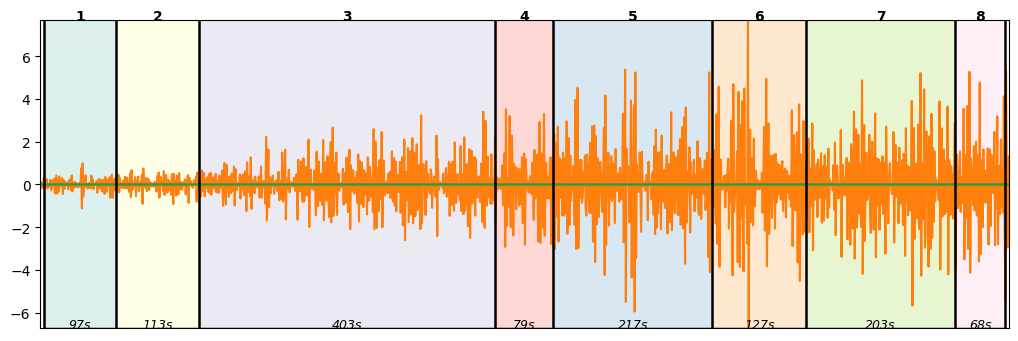

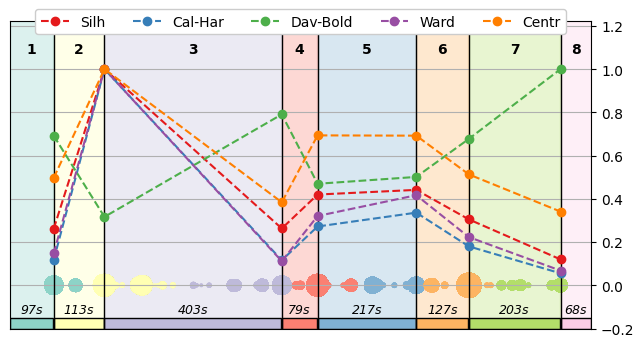

In [9]:
def read_traditional():
    df_ft_psd_loc_db = pandas.read_feather(f'{subj}/src/df_ft_psd_loc_db.feather')
    df_ft_psd_ind_loc_log = pandas.read_feather(f'{subj}/src/df_ft_psd_ind_loc_log.feather')
    df_ft_coh_ind_loc = pandas.read_feather(f'{subj}/src/df_ft_coh_ind_loc.feather')
    df_ft_plv_ind_loc = pandas.read_feather(f'{subj}/src/df_ft_plv_ind_loc.feather')

    result =  pandas.concat([
        df_ft_psd_loc_db,
        df_ft_psd_ind_loc_log,
        df_ft_coh_ind_loc,
        df_ft_plv_ind_loc
    ], axis = 1)

    if subj == "Subj2":
        result = result[:-2]
    return result

analyze(read_traditional(), 15, "traditional")

#### Топологические признаки + QSDA + PCA

(1249, 1182)
(1249, 15)
Explained variance 0.73
[0.319, 0.083, 0.046, 0.042, 0.038, 0.034, 0.031, 0.023, 0.021, 0.02, 0.017, 0.016, 0.014, 0.014, 0.013]
Applying to 1249 samples with 15 features each


stage 2: 100%|██████████| 672/672 [00:11<00:00, 58.96it/s]


,St_len_min,K_nb_max,N_cl_max,Cl_cen,Len_min,St_edges,N_stages,Longest_stage,Shortest_stage,Avg_stage_length,Ward_dist,Cen_dist,Silh,Cal-Har,Dav-Bold,Avg-Silh,Avg-Cal-Har,Avg-Dav-Bold
0,0,40,20,Mode,40,"[0, 90, 206, 774, 900, 998, 1094, 1171, 1249]",8,568,77,156.125,39356.501876,23.923402,0.039047,79.439094,4.036462,0.211272,72.035126,1.806457


array([   0,   90,  206,  774,  900,  998, 1094, 1171, 1249])

,0,1,2,3,4,5,6,7
"Start-end time, sec","(5.5, 98.5)","(99.5, 219.5)","(220.5, 816.5)","(817.5, 949.5)","(950.5, 1059.5)","(1060.5, 1155.5)","(1156.5, 1238.5)","(1239.5, 1319.5)"
"Time length, sec",93.0,120.0,596.0,132.0,109.0,95.0,82.0,80.0
Number of epochs,90,116,568,126,98,96,77,78


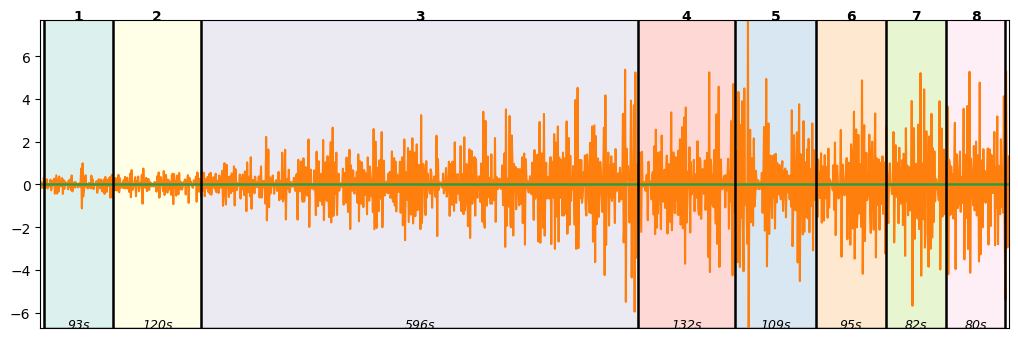

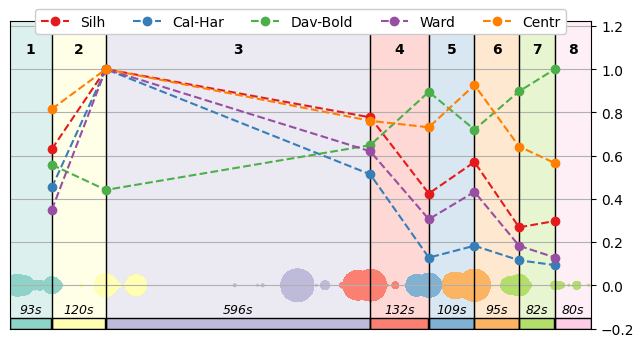

In [12]:
analyze(best_features, 15, "best_topological")

#### Традиционные и топологические вместе + PCA

(1249, 1523)
(1249, 15)
Explained variance 0.69
[0.273, 0.099, 0.05, 0.046, 0.036, 0.03, 0.028, 0.023, 0.02, 0.017, 0.016, 0.015, 0.013, 0.012, 0.011]
Applying to 1249 samples with 15 features each


stage 2: 100%|██████████| 672/672 [00:10<00:00, 65.80it/s]


,St_len_min,K_nb_max,N_cl_max,Cl_cen,Len_min,St_edges,N_stages,Longest_stage,Shortest_stage,Avg_stage_length,Ward_dist,Cen_dist,Silh,Cal-Har,Dav-Bold,Avg-Silh,Avg-Cal-Har,Avg-Dav-Bold
0,20,35,15,Median,40,"[0, 54, 205, 731, 879, 998, 1094, 1182, 1249]",8,526,54,156.125,47280.292707,25.386393,0.066024,89.319348,3.595065,0.198206,74.246815,1.914313


array([   0,   54,  205,  731,  879,  998, 1094, 1182, 1249])

,0,1,2,3,4,5,6,7
"Start-end time, sec","(5.5, 61.5)","(62.5, 218.5)","(219.5, 771.5)","(772.5, 924.5)","(925.5, 1059.5)","(1060.5, 1155.5)","(1156.5, 1249.5)","(1250.5, 1319.5)"
"Time length, sec",56.0,156.0,552.0,152.0,134.0,95.0,93.0,69.0
Number of epochs,54,151,526,148,119,96,88,67


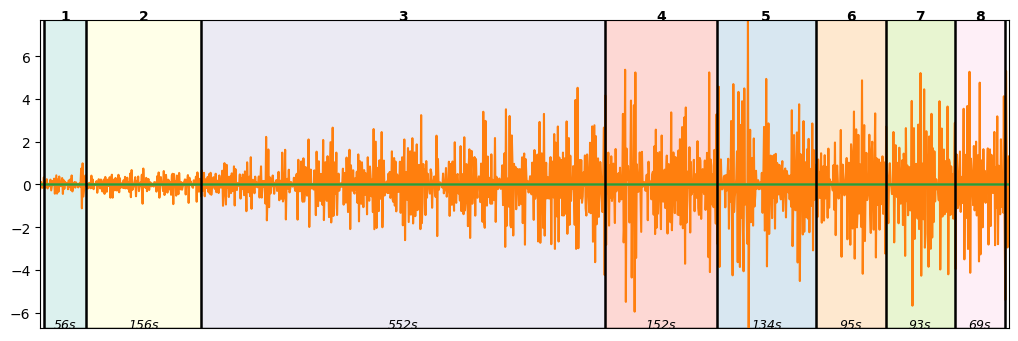

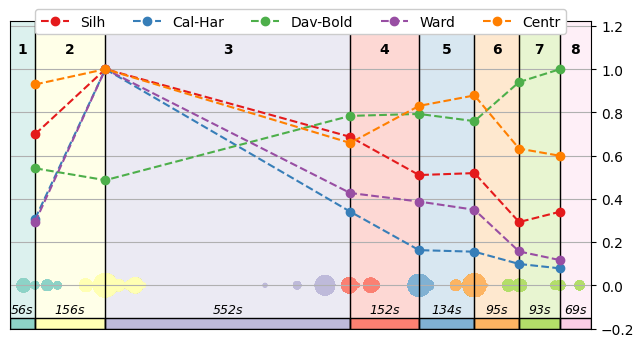

In [13]:
combined_features = pandas.concat([ read_traditional(), best_features ], axis = 1)
analyze(combined_features, 15, "combined")

### Information value

In [11]:
result_edges = numpy.loadtxt(f"{subj}/{exp}/results/best_topological/best_edges.txt").astype(numpy.int32)
print(result_edges)

if os.path.exists(f"{subj}/{exp}/IV/IV.csv"):
    ivs = pandas.read_csv(f"{subj}/{exp}/IV/IV.csv")
else:
    _, labels = SDA.stageprocess.form_stage_bands(result_edges)
    ivs = SDA.analytics.IV.calc_IV_clust(features, labels)

    os.makedirs(f"{subj}/{exp}/IV", exist_ok = True)
    ivs.to_csv(f"{subj}/{exp}/IV/IV.csv", index = False)

ivs["normalized_iv"] = sklearn.preprocessing.MinMaxScaler().fit_transform(ivs[["IV"]])
display(ivs)

[  0 105 249 479 588 671 830 922]


IV: 100%|██████████| 4644/4644 [00:17<00:00, 269.72it/s]


,Feature,IV,IVs,normalized_iv
0,channel-0 landscape dim-1 max,0.634166,"[0.15161803413433816, 0.2999318126575721, 0.36...",0.225357
1,channel-0 landscape dim-1 mean,0.623755,"[0.20809079138330785, 0.2951683025788348, 0.34...",0.221072
2,channel-0 landscape dim-1 std,0.661541,"[0.22999432725547178, 0.3172817130706948, 0.41...",0.236627
3,channel-0 landscape dim-1 sum,0.623755,"[0.20809079138330785, 0.2951683025788348, 0.34...",0.221072
4,channel-0 landscape dim-1 norm-1,0.623755,"[0.20809079138330785, 0.2951683025788348, 0.34...",0.221072
...,...,...,...,...
4639,overall bd2 dim-3 mean,0.567355,"[0.7694638340763805, 0.21981479703616064, 0.34...",0.197854
4640,overall bd2 dim-3 std,0.161894,"[0.12990743243901828, 0.05229321240431985, 0.0...",0.030941
4641,overall bd2 dim-3 sum,0.320776,"[0.4405759536380309, 0.08703564790815038, 0.28...",0.096347
4642,overall bd2 dim-3 norm-1,0.320776,"[0.4405759536380309, 0.08703564790815038, 0.28...",0.096347


In [12]:
iv_qsda_scores = scores.join(ivs, lsuffix = "name", rsuffix = "Feature")
iv_qsda_scores = iv_qsda_scores[["name", "unique_values", "score", "normalized_score", "IV", "normalized_iv"]]

iv_qsda_scores["score"] = iv_qsda_scores["score"] * (iv_qsda_scores["unique_values"] >= UNIQUE_VALUES_THRESHOLD)
iv_qsda_scores["normalized_score"] = iv_qsda_scores["normalized_score"] * (iv_qsda_scores["unique_values"] >= UNIQUE_VALUES_THRESHOLD)

iv_qsda_scores = iv_qsda_scores.sort_values(by = 'score', ascending = False)
iv_qsda_scores["QSDA_IDX"] = numpy.arange(1, iv_qsda_scores.shape[0] + 1)

iv_qsda_scores = iv_qsda_scores.sort_values(by = 'IV', ascending = False)
iv_qsda_scores["IV_IDX"] = numpy.arange(1, iv_qsda_scores.shape[0] + 1)

iv_qsda_scores["IDX_DIFF"] = iv_qsda_scores["QSDA_IDX"] - iv_qsda_scores["IV_IDX"]

iv_qsda_scores = iv_qsda_scores.sort_index()
display(iv_qsda_scores)

,name,unique_values,score,normalized_score,IV,normalized_iv,QSDA_IDX,IV_IDX,IDX_DIFF
0,channel-0 landscape dim-1 max,922,1.285793,0.332239,0.634166,0.225357,3062,1252,1810
1,channel-0 landscape dim-1 mean,922,1.537303,0.404549,0.623755,0.221072,2219,1346,873
2,channel-0 landscape dim-1 std,922,1.540304,0.405411,0.661541,0.236627,2201,990,1211
3,channel-0 landscape dim-1 sum,922,1.537303,0.404549,0.623755,0.221072,2217,1344,873
4,channel-0 landscape dim-1 norm-1,922,1.537303,0.404549,0.623755,0.221072,2216,1345,871
...,...,...,...,...,...,...,...,...,...
4639,overall bd2 dim-3 mean,747,1.088618,0.275551,0.567355,0.197854,3645,1775,1870
4640,overall bd2 dim-3 std,574,1.361778,0.354085,0.161894,0.030941,2809,4351,-1542
4641,overall bd2 dim-3 sum,747,1.404474,0.366360,0.320776,0.096347,2673,3250,-577
4642,overall bd2 dim-3 norm-1,747,1.404474,0.366360,0.320776,0.096347,2672,3249,-577


<Axes: >

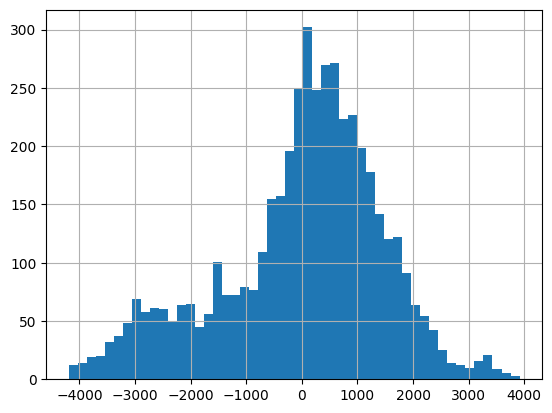

In [13]:
iv_qsda_scores["IDX_DIFF"].hist(bins = 50)

In [14]:
def vec_div(vec):
    mat1 = numpy.repeat(vec.reshape(-1, 1), repeats = len(vec), axis = 1)
    mat2 = numpy.repeat(vec.reshape(1, -1), repeats = len(vec), axis = 0)
    return numpy.sign(mat1 - mat2)

qsda = vec_div(iv_qsda_scores["score"].to_numpy())
iv = vec_div(iv_qsda_scores["IV"].to_numpy())

correct = ((qsda == iv).sum() - iv_qsda_scores.shape[0]) / 2
incorrect = ((qsda != iv).sum() - iv_qsda_scores.shape[0]) / 2

print(correct / 1e6, incorrect / 1e6)

6.935813 3.842911


In [15]:
def sourceFilter(row):
    if row['Source'].startswith('dissim'):
        return 'dissim'
    return row['Source']

iv_qsda_scores[["Source", "Algorithm", "Dimension", "Stat"]] = iv_qsda_scores['name'].str.split(' ', expand = True)
iv_qsda_scores["Source"] = iv_qsda_scores.apply(sourceFilter, axis = 1)
iv_qsda_scores.to_csv(f"{subj}/{exp}/IV/iv_qsda_scores.csv", index = False)

In [16]:
def SourceRenamer(initial: str) -> str:
    if initial == 'dissim':
        return 'Correlations analysis'
    if initial == 'overall':
        return 'Overall processing'
    ind = initial.find('-') + 1
    comp = int(initial[ind:])
    return f'Comp. {comp} (ch. {epochs.ch_names[comp]})'

def AlgorithmRenamer(row):
    return {
        'amplitude-betti-1':        'Betti amp. with p=1',
        'amplitude-betti-2':        'Betti amp. with p=2',

        'amplitude-bottleneck':     'Bottleneck amp.',
        'amplitude-wasserstein-1':  'Wasserstein amp. with p=1',
        'amplitude-wasserstein-2':  'Wasserstein amp. with p=2',
        
        'amplitude-landscape-1-1':  'Pers. landscape amp. with p=1',
        'amplitude-landscape-1-2':  'Pers. landscape amp. with p=1',
        'amplitude-landscape-2-1':  'Pers. landscape amp. with p=2',
        'amplitude-landscape-2-2':  'Pers. landscape amp. with p=2',
        
        'amplitude-silhouette-1-1': 'Pers. silhouette amp. with p=1',
        'amplitude-silhouette-1-2': 'Pers. silhouette amp. with p=1',
        'amplitude-silhouette-2-1': 'Pers. silhouette amp. with p=2',
        'amplitude-silhouette-2-2': 'Pers. silhouette amp. with p=2',

        'bd2':                      'Stat. char. of (b + d) / 2',
        'life':                     'Stat. char. of lifetimes',
        'betti':                    'Stat. char. of Betti curves',
        'landscape':                'Stat. char. of pers. landscape',
        'silhouette-1':             'Stat. char. of lvl 1 pers. silh.',
        'silhouette-2':             'Stat. char. of lvl 2 pers. silh.',
        
        'entropy':                  'Persistence entropy',
        'numberofpoints':           'Number of points',
    }[row]

def DimensionRenamer(row):
    return {
        'all':        'All',
        'dim-1':      'Dimension 1',
        'dim-2':      'Dimension 2',
        'dim-3':      'Dimension 3',
        'dim-4':      'Dimension 4',
        'dim-5':      'Dimension 5',
        'norm-1':     'Amplitude norm with p=1',
        'norm-2':     'Amplitude norm with p=2',
    }[row]

def StatRenamer(row):
    return {
        'kurtosis':      'Kurtosis',
        'skew':          'Skew',
        'max':           'Maximum',
        'mean':          'Mean',
        'median':        'Median',
        'norm-1':        'Norm with p=1',
        'norm-2':        'Norm with p=2',
        'percentile-25': 'Percentile - 25',
        'percentile-75': 'Percentile - 75',
        'std':           'Standard deviation',
        'sum':           'Sum',
    }[row]

def make_stats(data: pandas.DataFrame, group_by: str, sort_by: str):
    stats = data.groupby(by = group_by).mean(numeric_only = True)
    stats = stats.sort_values(by = sort_by).reset_index()
    stats.to_csv(f"{subj}/{exp}/IV/stats_{group_by}_{sort_by}.csv", index = False)
    return stats

def draw(
    data: pandas.DataFrame,
    group_by: str,
    sort_by: str,
    ax,
    renamer: typing.Callable[[str], str],
    title: str
):
    stats = make_stats(data, group_by, sort_by)
    stats[group_by] = stats[group_by].apply(renamer)
    stats.plot.barh(x = group_by, y = sort_by, ax = ax, xlim = (2 * stats[sort_by].min() / 3, None))

    ax.set_title(title)
    ax.get_legend().remove()
    ax.xaxis.set_label_text('')
    ax.yaxis.set_label_text('')

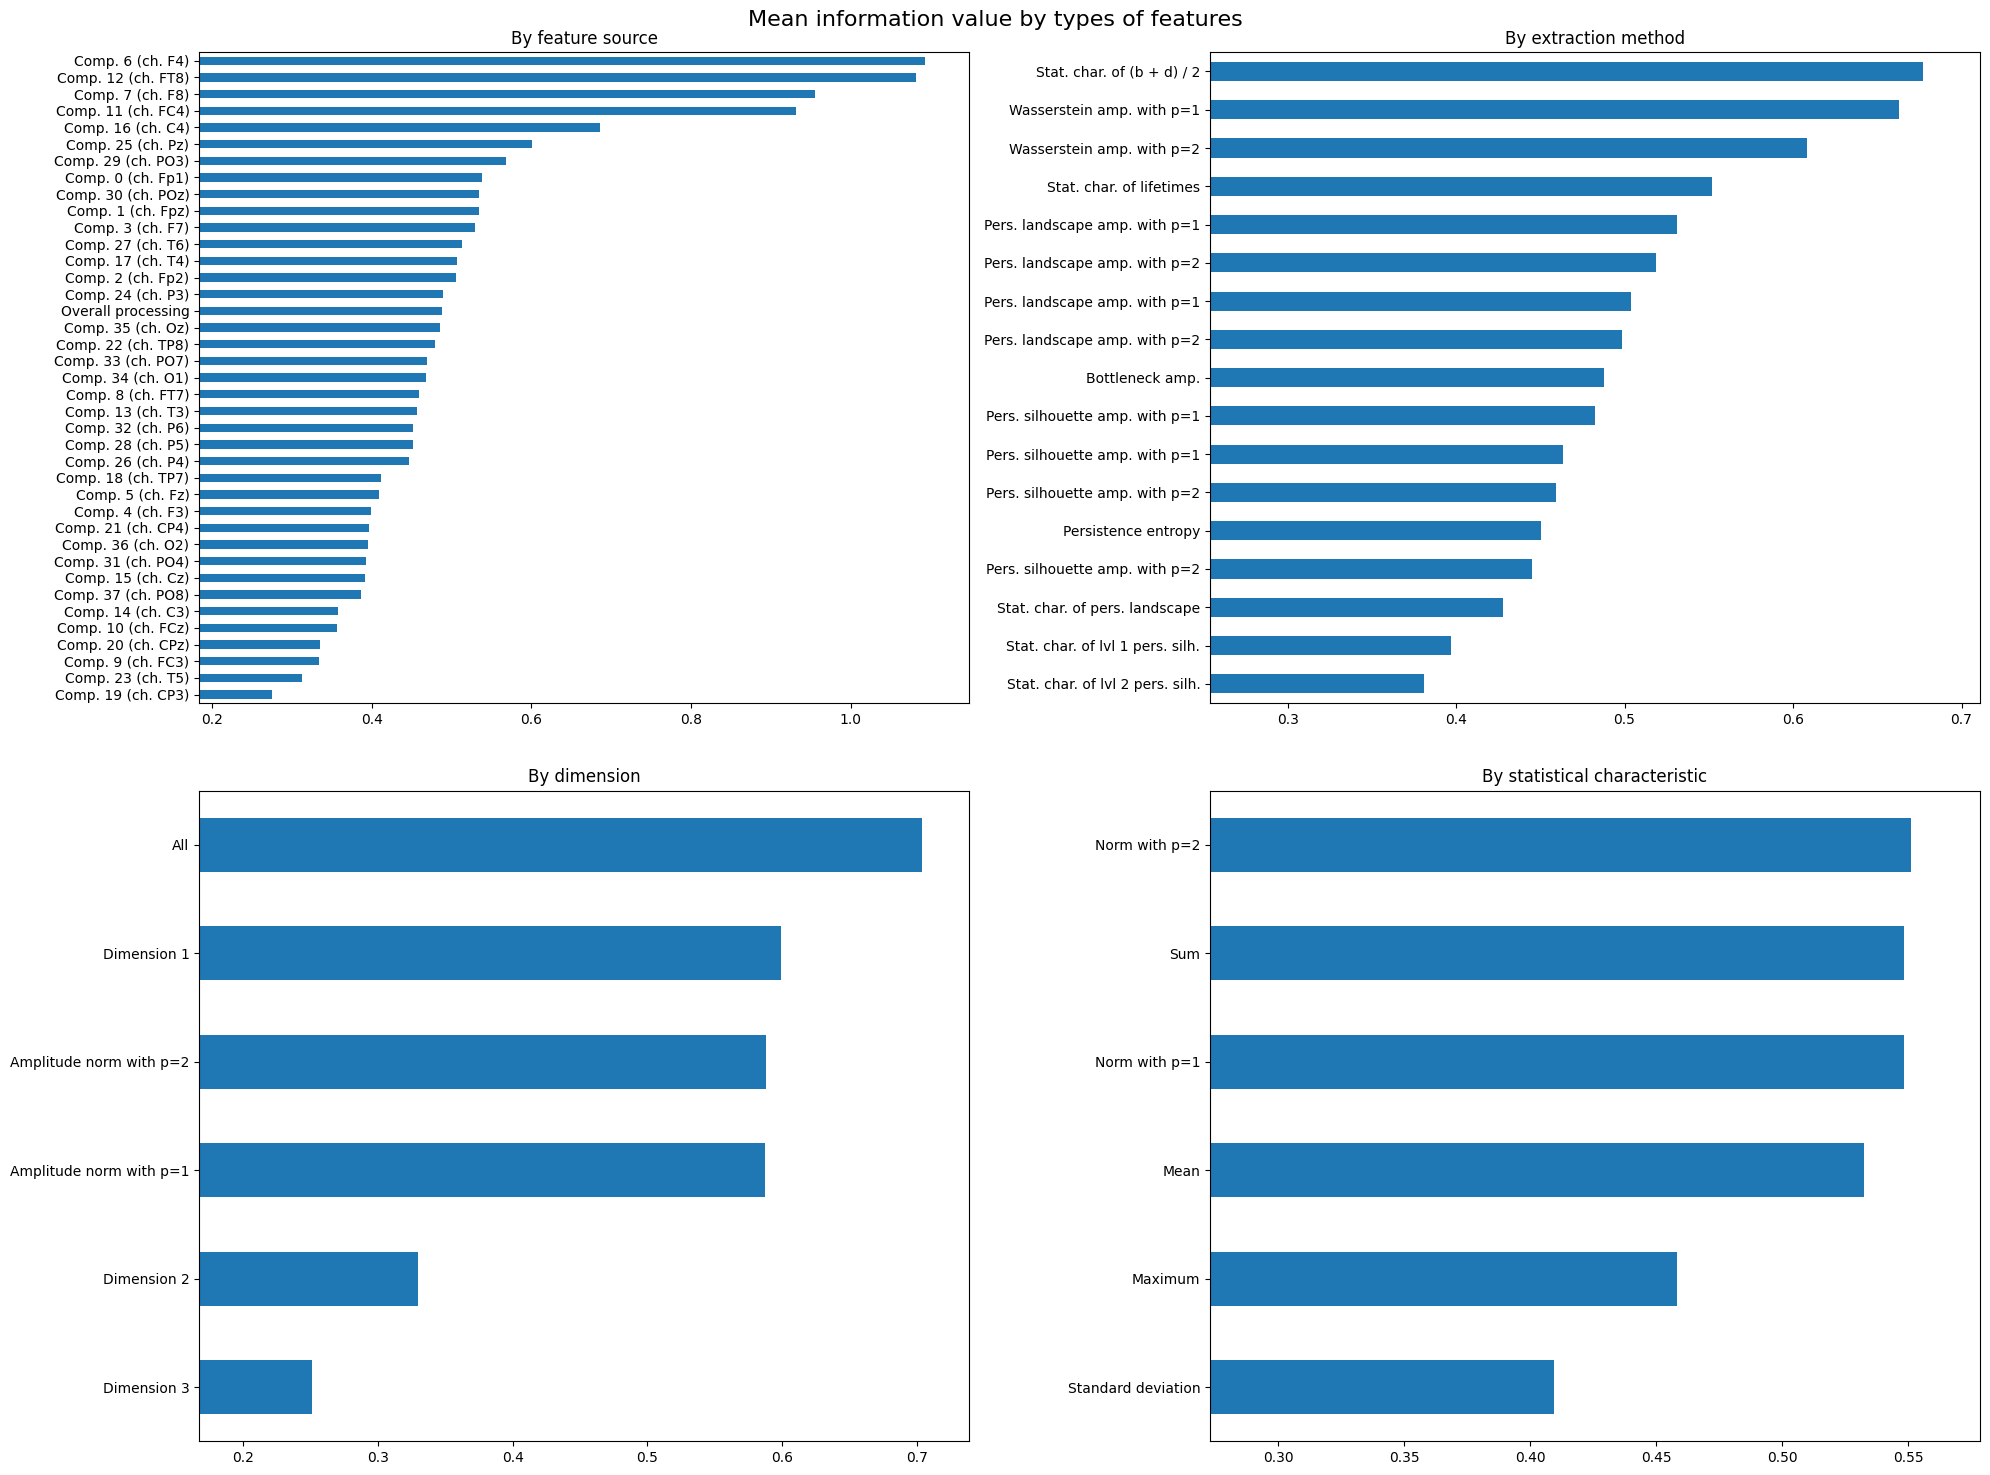

In [17]:
fig, axes = plt.subplots(2, 2, figsize = (20, 15))
fig.suptitle('Mean information value by types of features', fontsize = 16)

draw(iv_qsda_scores, 'Source', 'IV', axes.flat[0], SourceRenamer, 'By feature source')
draw(iv_qsda_scores, 'Algorithm', 'IV', axes.flat[1], AlgorithmRenamer, 'By extraction method')
draw(iv_qsda_scores, 'Dimension', 'IV', axes.flat[2], DimensionRenamer, 'By dimension')
draw(iv_qsda_scores, 'Stat', 'IV', axes.flat[3], StatRenamer, 'By statistical characteristic')

fig.tight_layout(h_pad = 3)
fig.savefig(f"{subj}/{exp}/IV/feature_agg_by_iv.svg")
fig.savefig(f"{subj}/{exp}/IV/feature_agg_by_iv.png")

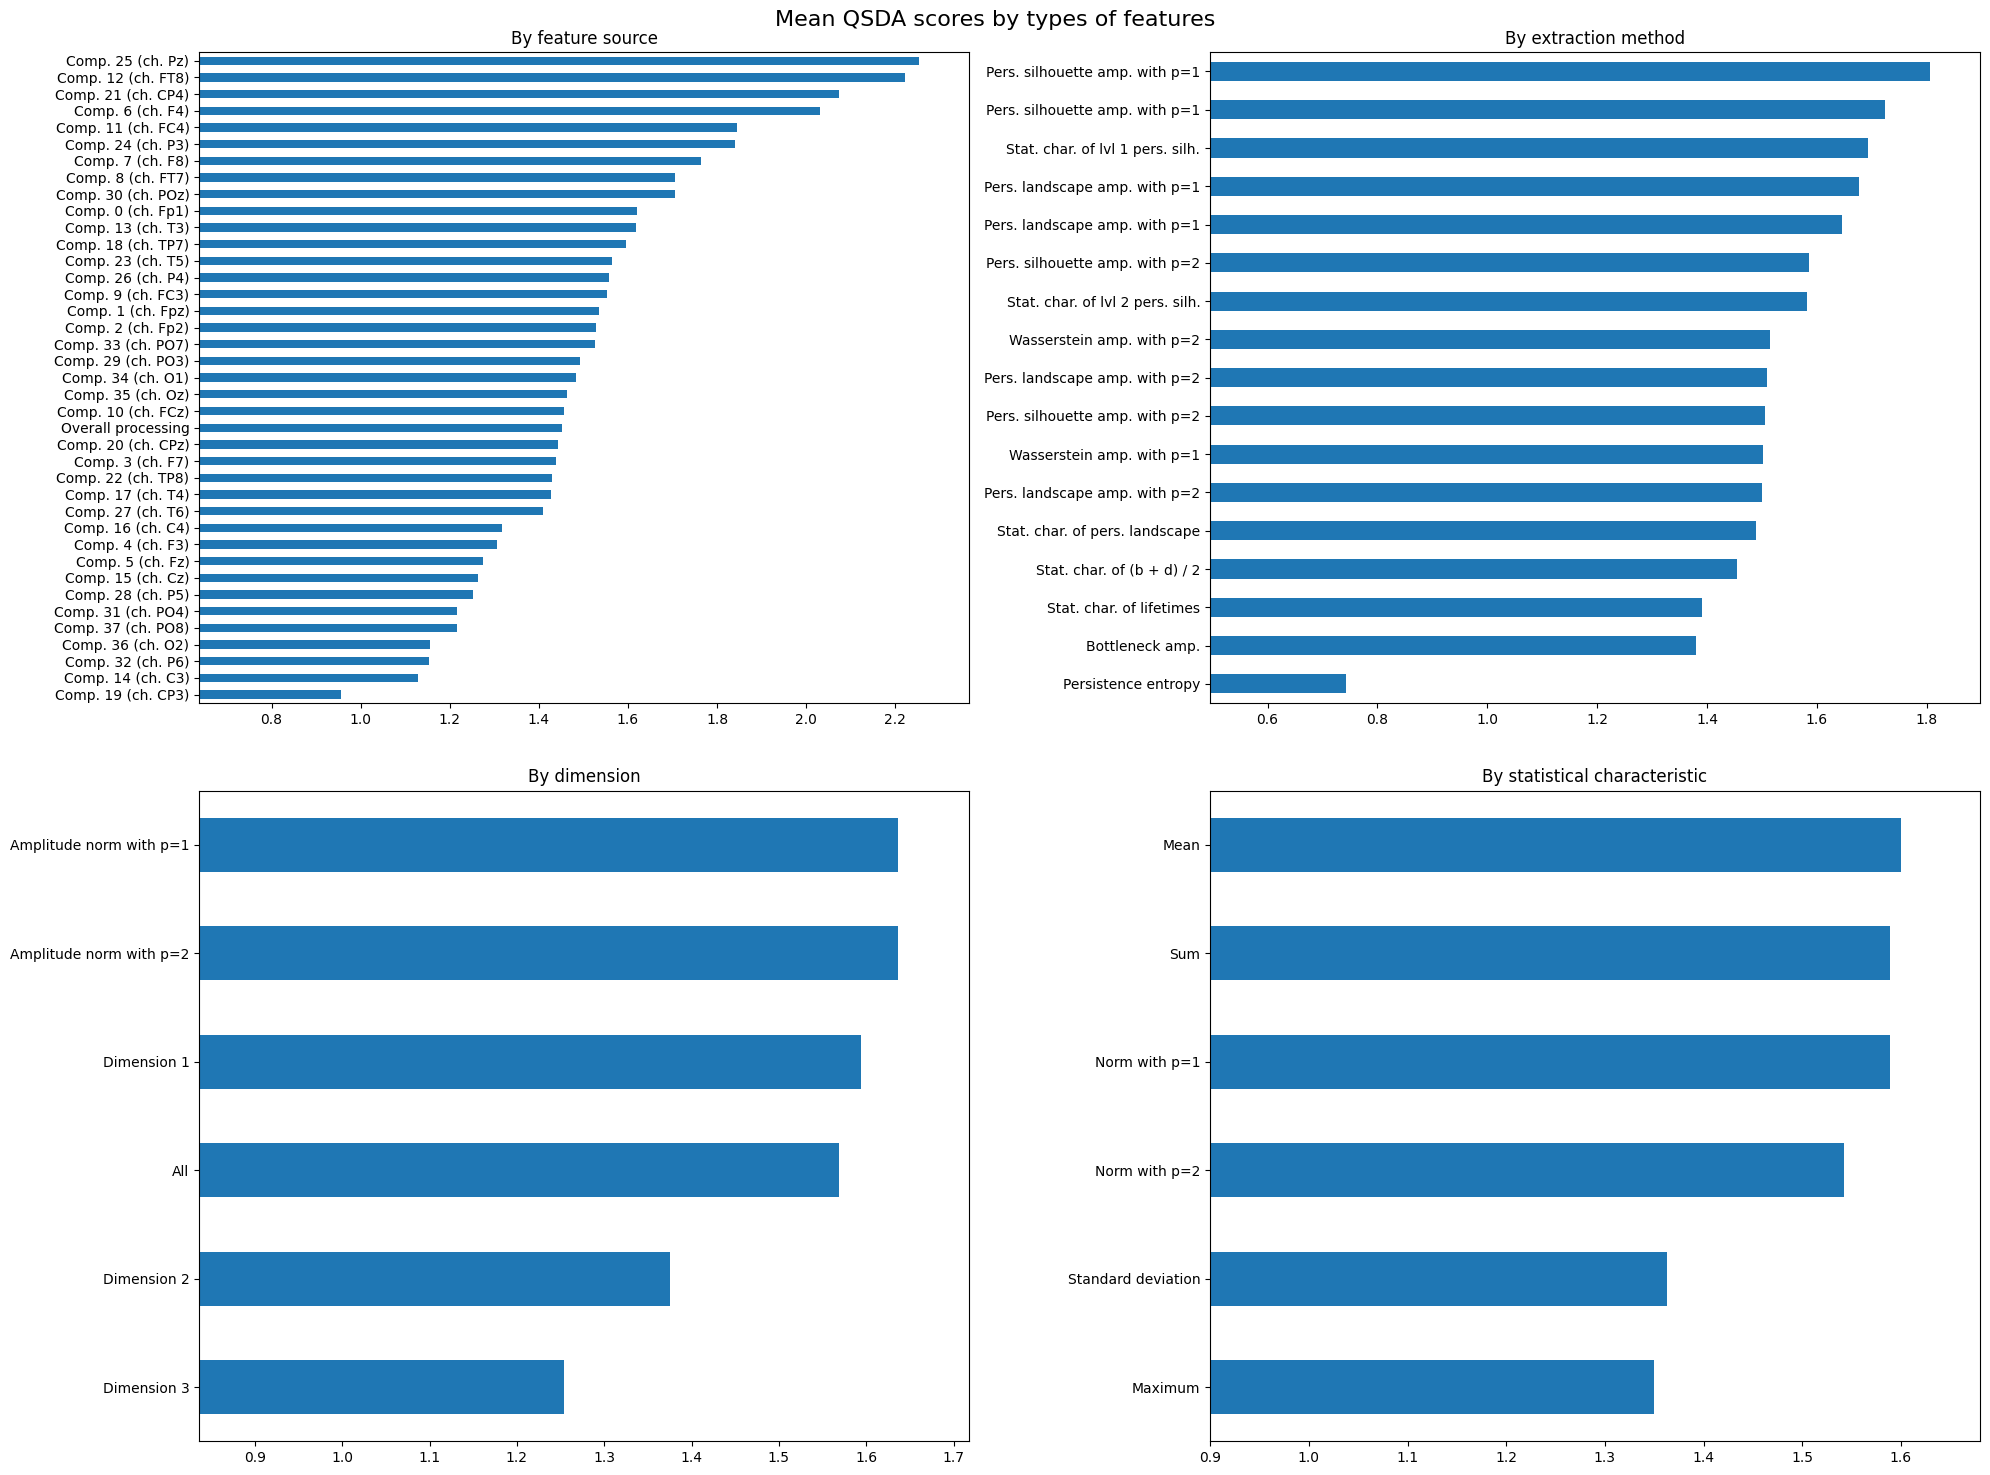

In [18]:
fig, axes = plt.subplots(2, 2, figsize = (20, 15))
fig.suptitle('Mean QSDA scores by types of features', fontsize = 16)

draw(iv_qsda_scores, 'Source', 'score', axes.flat[0], SourceRenamer, 'By feature source')
draw(iv_qsda_scores, 'Algorithm', 'score', axes.flat[1], AlgorithmRenamer, 'By extraction method')
draw(iv_qsda_scores, 'Dimension', 'score', axes.flat[2], DimensionRenamer, 'By dimension')
draw(iv_qsda_scores, 'Stat', 'score', axes.flat[3], StatRenamer, 'By statistical characteristic')

fig.tight_layout(h_pad = 3)
fig.savefig(f"{subj}/{exp}/IV/feature_agg_by_qsda.svg")
fig.savefig(f"{subj}/{exp}/IV/feature_agg_by_qsda.png")

In [19]:
def draw_sources_heatmap(data: pandas.DataFrame, sort_by: str):
    svg = open("report/regions/regions.svg", "r").read()
    svg = svg[svg.find('>') + 1:svg.rfind('<') - 1]
    defs = ""

    stats = make_stats(data, "Source", sort_by)[["Source", sort_by]]
    stats = stats[stats.apply(lambda row: row['Source'].startswith('channel-'), axis = 1)]

    min, max = stats[sort_by].min(), stats[sort_by].max()
    colors = [[ 1, 0.25, 0 ], [ 1, 0.66, 0 ], [ 1, 0.75, 0 ], [ 0.66, 0.8, 0 ], [ 0.25, 1, 0 ]]
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list('rg', colors, N = int((max - min) * 1000))

    for _, row in stats.iterrows():
        score = int((row[sort_by] - min) * 1000)
        color = matplotlib.colors.rgb2hex(cmap(score))

        id = int(row['Source'][row['Source'].find('-') + 1:])
        id_index = svg.index(f'id="{id}"')
        path_start = svg.rfind("<", 0, id_index)
        path_end = svg.find(">", id_index)

        path = svg[path_start:path_end+1]
        m_idx = path.find("M")
        x = float(path[m_idx + 1:m_idx + 7])
        y = float(path[m_idx + 8:m_idx + 15])

        defs += f"""
            <radialGradient id="gradient{id}">
                <stop offset="0%" stop-color="{color}" stop-opacity="0.66"></stop>
                <stop offset="100%" stop-color="{color}" stop-opacity="0"></stop>
            </radialGradient>
        """
        part = f"""
            <circle cx="{x}" cy="{y - 2}" r="50" fill="url(#gradient{id})"></circle>
            {path.replace(f'id="{id}"', f'fill="{color}" stroke="{color}"')}
        """

        svg = svg[:path_start] + part + svg[path_end+1:]

    svg = f"""
        <svg viewBox="0 0 530 528" fill="none" xmlns="http://www.w3.org/2000/svg">
            <defs> {defs} </defs> {svg}
        </svg>
    """

    file = f"{subj}/{exp}/IV/{sort_by}_regions.svg"
    open(file, "w").write(svg)
    return IPython.display.SVG(file)

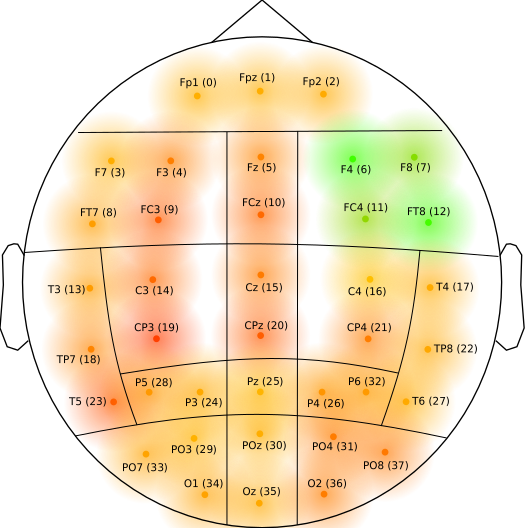

In [20]:
draw_sources_heatmap(iv_qsda_scores, "IV")

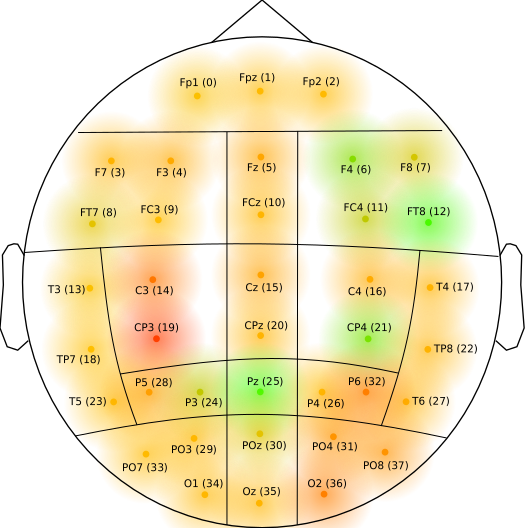

In [21]:
draw_sources_heatmap(iv_qsda_scores, "score")